<a href="https://colab.research.google.com/github/chenyu66666/W16-project/blob/master/LSTM/apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
<ipython-input-4-21751f4dfd6b>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


數據的基本資訊（df.info()）：
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  3522 non-null   float64
 1   (Close, AAPL)      3522 non-null   float64
 2   (High, AAPL)       3522 non-null   float64
 3   (Low, AAPL)        3522 non-null   float64
 4   (Open, AAPL)       3522 non-null   float64
 5   (Volume, AAPL)     3522 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.6 KB

檢查各列是否存在缺失值（NaN）：
Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64

填補缺失值後的數據概況：
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  ----- 

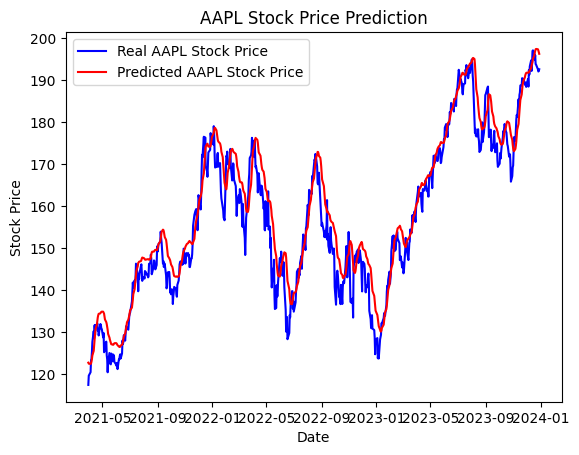

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# 下載 AAPL 股票數據
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

# 檢查是否有缺失值
print("數據的基本資訊（df.info()）：")
data.info()  # 顯示 DataFrame 的摘要信息，查看是否有 NaN

# 檢查缺失值的總數
print("\n檢查各列是否存在缺失值（NaN）：")
print(data.isnull().sum())  # 檢查每列的缺失值數量

# 如果存在缺失值，使用前向填充方法（ffill）填補
data = data.fillna(method='ffill')

# 再次檢查是否有缺失值
print("\n填補缺失值後的數據概況：")
data.info()  # 顯示填補後的摘要信息
print("\n填補後的缺失值檢查：")
print(data.isnull().sum())  # 檢查填補後是否還有缺失值

# 使用調整過的收盤價
data = data[['Adj Close']]

# 特徵縮放
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 準備訓練數據
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # reshape for LSTM

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 預測股價
predicted_stock_price = model.predict(X_test)

# 還原預測的股價
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 提取測試集對應的日期
test_dates = data.index[-len(y_test_rescaled):]

# 可視化結果，使用日期作為 x 軸
plt.plot(test_dates, y_test_rescaled, color='blue', label='Real AAPL Stock Price')
plt.plot(test_dates, predicted_stock_price, color='red', label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# 保存圖像為 PNG 文件
plt.savefig('AAPL_pred.png', dpi=300, bbox_inches='tight')

# 顯示圖形
plt.show()
